# Инициализация

In [1]:
from autoencoder import *

# Запуск

In [2]:
import matplotlib.pyplot as plt
import pickle


# Загрузка изображений (28.5 MB)
url = "https://huggingface.co/pogorzelskich/clagnosco_2025-05-11/resolve/main/images_origin.pkl?download=true"
response = requests.get(url)
response.raise_for_status()
images_origin = pickle.loads(response.content)

# Загрузка модели (1.23 GB)
url = "https://huggingface.co/pogorzelskich/clagnosco_2025-05-11/resolve/main/model.pt?download=true"
model, _ = model_loader(url)
model.eval()

images_reconstructed = []
for img in images_origin:
    images_reconstructed.append(run_image_through_autoencoder(model, img)[1])

model

Загрузка модели из https://huggingface.co/pogorzelskich/clagnosco_2025-05-11/resolve/main/model.pt?download=true


Скачивание модели: 100%|██████████| 1.16G/1.16G [00:31<00:00, 36.6MB/s]


ClagnoscoAutoencoder(
  (encoder): ClagnoscoEncoder(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
      (6): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(4, 4))
    (lin): Sequential(
      (0): Linear(in_features=8192, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=2048, out_featur

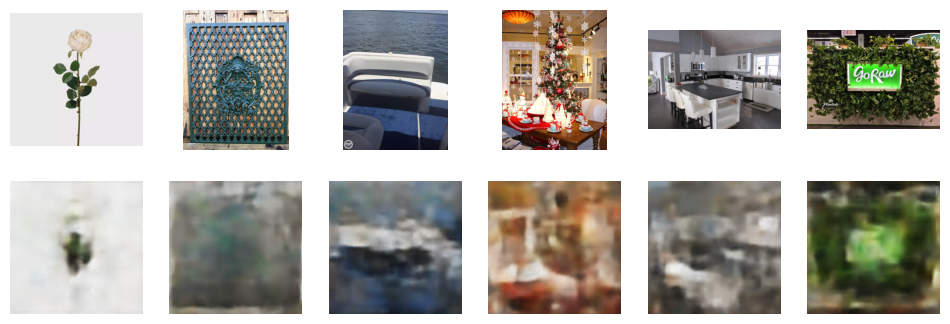

In [3]:
# PLT Оригиналы и реконструкции
img_count = 6
start_img = 6
fig, axs = plt.subplots(2, img_count, figsize=(img_count * 2, 4))
for i in range(start_img, img_count+start_img):
    axs[0, i-start_img].imshow(images_origin[i], cmap='gray')
    axs[0, i-start_img].axis('off')
    axs[1, i-start_img].imshow(images_reconstructed[i], cmap='gray')
    axs[1, i-start_img].axis('off')
plt.show()
